In [1]:
from anomaly import io, tmm, adm
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np

import anomaly.utils.modelselect_utils as mu
import anomaly.utils.statsutils as su
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
predictor_dict = {
"naive_predictor" : tmm.NaivePredictor(),
"ar5_predictor" : tmm.AR(order=5),
"ma5_predictor" : tmm.MA(order=5),
"arma55_predictor" : tmm.ARMA(order_ar=5, order_ma=5),
"arima525_predictor" : tmm.ARIMA.ARIMA(order=[5,2,5]),
"poly5_predictor" : tmm.Polynomial(degree=5),
}

### Compute the features and the scores of the models for each time series in the benchmark

Compute features:

In [3]:
%%capture --no-stdout

for benchmark_index in range(1,5):
    bench = io.BenchmarkDataset(benchmark_index)
    
    features = mu.compute_benchmark_features(bench)
    features.to_csv(f"saved_data/features_{benchmark_index}.csv", index_label="ts_index")

100%|████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.50it/s]


Compute scores:

In [ ]:
%%capture --no-stdout

for benchmark_index in range(3,5):
    bench = io.BenchmarkDataset(benchmark_index)

    score_dict = mu.compute_predictor_scores(predictor_dict, bench, detector=adm.KSigma())
    score_df = pd.concat([score_dict[model_name].assign(model_name=model_name)
                      for model_name in score_dict.keys()])
    
    score_df.to_csv(f"saved_data/score_df_{benchmark_index}.csv", index_label="ts_index")

### Analyse the results

#### Read the saved data

In [15]:
benchmark_index = 2

In [16]:
score_df = pd.read_csv(f"saved_data/score_df_{benchmark_index}.csv").set_index("ts_index")
features = pd.read_csv(f"saved_data/features_{benchmark_index}.csv").set_index("ts_index")

In [17]:
features_normalized = (features - features.mean()) / features.std()
features_normalized

,periodicity,trend_score,seasonality_score,nonlinearity,skew,kurtosis,hurst,lyapunov
ts_index,,,,,,,,
0,-0.420820,-0.595007,0.312873,-0.182623,-0.335106,-0.366688,-0.518623,0.167419
1,-0.605100,0.917413,0.404204,0.870784,1.174994,0.454108,2.468215,1.824691
2,1.498770,-0.050875,0.398236,-0.182313,0.774276,0.331808,-0.412896,-0.327003
3,-0.420820,-0.415120,0.346496,-0.184900,-0.412266,-0.387908,0.187044,-1.159938
4,-0.420820,-3.284431,0.396720,-0.183644,-0.547299,-0.429557,-1.188156,-0.696023
...,...,...,...,...,...,...,...,...
62,2.773377,-0.602988,0.324246,0.410316,0.148304,-0.291704,1.054703,-0.366034
63,2.804091,0.108589,0.391706,-0.185024,-0.334275,-0.401550,-1.366557,-0.866006
64,0.500583,-0.431384,0.324238,-0.184047,-0.595419,-0.429205,-0.821832,0.143584


In [18]:
score_df

,bias,mad,mape,mse,sae,f1,recall,model_name
ts_index,,,,,,,,
0,-5.779907e-05,0.102038,5.823691e-02,2.135478e-02,1.490772e+02,0.380952,0.444444,naive_predictor
1,2.328700e+00,826.596942,7.493379e-02,3.541867e+07,1.189473e+06,0.538462,0.368421,naive_predictor
2,-1.330986e-01,66.882394,3.889694e-01,2.579828e+04,9.497300e+04,0.666667,0.666667,naive_predictor
3,-8.577435e+00,4180.570427,1.928091e-01,5.469487e+07,5.965674e+06,0.454545,0.500000,naive_predictor
4,-9.848658e-05,0.037458,1.265335e-01,2.328306e-03,5.472611e+01,0.000000,0.000000,naive_predictor
...,...,...,...,...,...,...,...,...
62,-9.209822e-14,35.885306,1.509381e+07,3.951265e+03,5.149541e+04,0.534653,0.627907,poly5_predictor
63,-7.288633e-15,116.264215,5.241999e+05,2.879755e+04,1.668391e+05,0.000000,0.000000,poly5_predictor
64,2.567316e-12,2787.724851,3.150577e-01,1.134587e+07,4.011536e+06,0.666667,0.500000,poly5_predictor


#### Find the best model for each time-series

In [20]:
pivot_init = score_df[["f1", "model_name"]]
df = pd.pivot_table(pivot_init, index="ts_index", columns="model_name", values="f1")

df_np = df.to_numpy()
best_model = df_np.argmax(axis=1)

#### Plot the results depending on the features using PCA

In [21]:
from sklearn import decomposition

features_np = features_normalized.to_numpy()

pca = decomposition.PCA(n_components=2)
XY = pca.fit_transform(features_np)

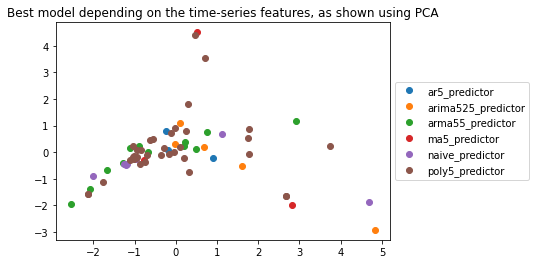

In [22]:
plot_df = pd.DataFrame(XY, columns=["X", "Y"])
plot_df["category"] = np.array(list(predictor_dict.keys()))[best_model]

groups = plot_df.groupby("category")
for name, group in groups:
    plt.plot(group["X"], group["Y"], marker="o", linestyle="", label=name)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Best model depending on the time-series features, as shown using PCA")

plt.savefig("figs/best_model_PCA.png",  bbox_inches = 'tight')

### See how each feature affects the fscore using a linear regression

In [23]:
import statsmodels.formula.api as smf

for predictor_name in ["poly5_predictor", "ma5_predictor"]:
    print(f"------------------------- {predictor_name} --------------------------------")
    score_model_df = score_df[score_df["model_name"] == predictor_name].reset_index(drop=True)
    
    df = features_normalized.join(score_model_df,  on="ts_index")
    
    smresults = smf.ols('f1 ~ trend_score + seasonality_score + nonlinearity + skew + kurtosis + hurst + lyapunov', df).fit()
    smresults_robust = smresults.get_robustcov_results()
    print(smresults_robust.summary())

------------------------- poly5_predictor --------------------------------
                            OLS Regression Results                            
Dep. Variable:                     f1   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     20.60
Date:                Wed, 30 Mar 2022   Prob (F-statistic):           1.03e-13
Time:                        19:39:00   Log-Likelihood:                -8.8122
No. Observations:                  67   AIC:                             33.62
Df Residuals:                      59   BIC:                             51.26
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

### Compare fscores of the pipeline

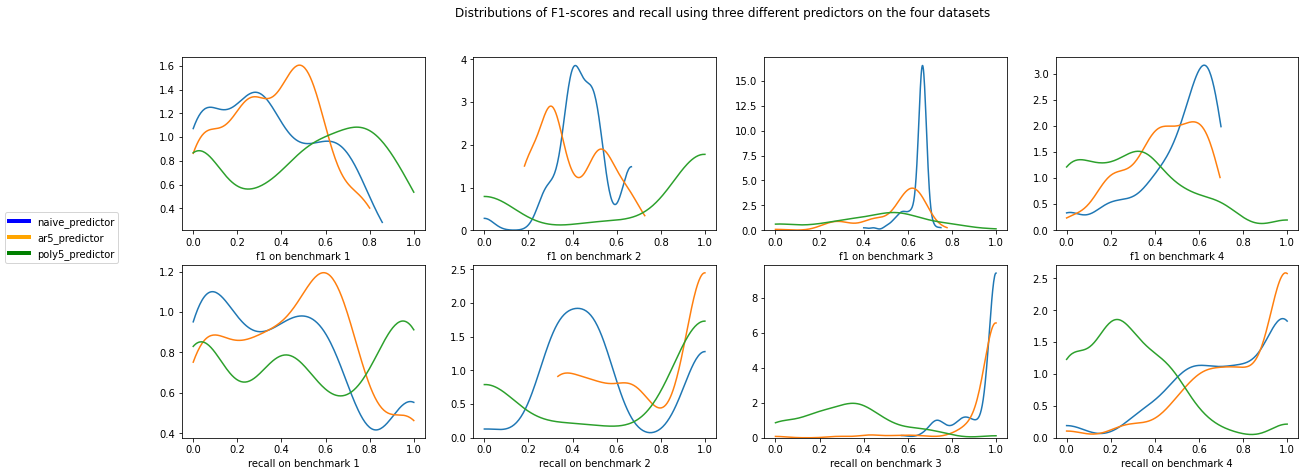

In [24]:
keep = [
    "naive_predictor",
    "ar5_predictor",
    "poly5_predictor",
]

fig, axes = plt.subplots(2,4, sharex=False, sharey=False, figsize=(20,7))
fig.suptitle('Distributions of F1-scores and recall using three different predictors on the four datasets')

scores = ["f1", "recall"]
benchmarks = [f"benchmark_{i}" for i in range(1,5)]


for j in range(len(benchmarks)):
    benchmark_index = j + 1
    score_df = pd.read_csv(f"saved_data/score_df_{benchmark_index}.csv").set_index("ts_index")
    
    for i in range(len(scores)):
        for model_name in keep:
            score_df_to_plot = score_df[score_df.model_name == model_name].reset_index()
            sns.kdeplot(data=score_df_to_plot, x=scores[i],
                   bw_adjust=.8, cut=0, ax=axes[i,j])
            
        axes[i,j].set_ylabel("")
        axes[i,j].set_xlabel(f"{scores[i]} on benchmark {benchmark_index}")
            
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="orange", lw=4),
                Line2D([0], [0], color="green", lw=4)]



fig.legend(custom_lines, keep, loc="center left")
plt.savefig("figs/F1_recall.png",  bbox_inches = 'tight')